<h1> Uniform Manifold Approximation and Projection </h1>  

<h3>https://ichi.pro/ko/cheoeumbuteo-umapeul-peulogeulaeminghaneun-bangbeob-253918307112446 / https://arxiv.org/pdf/1802.03426.pdf 를 많이 참조함 </h3>

In [1]:
import pandas as pd 
import numpy as np
from sklearn import datasets
import sklearn
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import trange
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import SpectralEmbedding
import matplotlib.animation as animation
import soydata

In [2]:
class UMAP(object):
    def __init__(self, n_neighbors:int, n_components:int, min_dist:float = .1, spread:float = 1., n_epoch = 300, random_state = None):
        self.n_neighbors = n_neighbors
        if min_dist > 1:
            raise ValueError('min dist must be same or lower than 1')
        else:
            self.min_dist = min_dist
        self.n_components = n_components
        self.n_epoch = n_epoch
        self.random_state = random_state
        self.spread = spread
        
    def fit_transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        self.n_ = X.shape[0]
        rgen = np.random.RandomState(self.random_state)
        
        #step1. construct high-dimention prop P
        dist = euclidean_distances(X,X)
        rho = np.where(dist.argsort(0).argsort(0)==1, dist, 0).sum(axis = 0)
        dist = np.maximum(np.zeros(shape = dist.shape), dist - np.column_stack([rho for _ in range(self.n_)]))
        
        sigma = []
        def compute_sum_prop(sigma, row):
            return np.sum(np.exp(-(row/sigma)))       
        for row in dist:
            sigma_l = 0.
            sigma_h = 1000.
            for i in range(100):
                sigma_c = (sigma_l + sigma_h)/2.
                c_s = compute_sum_prop(sigma_c, row)
                if self.n_neighbors - c_s < 1e-5:
                    sigma.append(c_s)
                    break
                if c_s < self.n_neighbors:
                    sigma_l = sigma_c
                else:
                    sigma_h = sigma_c
        
        P = np.exp( -(dist / np.column_stack([sigma for _ in range(len(dist))])) )
        P = P + P.T - (P*P.T)
        
        #step2. construct low dimension and compute hyperparameter a and b
        try :
            reducer = SpectralEmbedding(n_components = self.n_components, n_neighbors = self.n_neighbors, random_state = self.random_state)
            self.low_dimension_ = reducer.fit_transform(P)
        except:
            self.low_dimension_ = rgen.standard_t(loc = 0., scale = 1 , size = self.n_ * self.n_components).reshape(self.n, self.n_components)
        
        dist_low_dim_ = lambda dist, a, b: np.power(( 1 + a * np.power(dist, 2*b) ), -1)
        def get_a_b_(min_dist):
            x = np.linspace(0,3,300)
            y = np.where(x <= min_dist, 1, np.exp(-x + min_dist))
            p, _ = optimize.curve_fit(dist_low_dim_, x, y)
            return p
        self.a_, self.b_ = get_a_b_(self.min_dist)
        
#         return P, self.low_dimension_, self.a_, self.b_
        
        #step3. adjust low dimension location by gradient descent for n_iter times
        alpha = 1.
        
        def compute_grad(P, low_dim_, a, b):
            dist = sklearn.metrics.pairwise.euclidean_distances(low_dim_) + 1e-5
            Q = 1./1 + (a * ( dist ** (2.*b)) )
            return  np.sum(np.expand_dims(low_dim_, axis = 1) - np.expand_dims(low_dim_, axis = 0), axis = 1) * np.sum((Q * (2 * a * b * (dist ** (2 * (b-1))) * P)) - (Q * ( 2 * b * (1. - P) / dist )), axis = 1)[:, None]
        
        self.history_ = []
        
        #original umap uses negative sampling and sgd, but just used gd
        def compute_grad(P, low_d_, a_, b_):
            dist = euclidean_distances(low_d_)
            Q = np.power(1. + (a_ * np.power(dist, 2. * b_)),-1)
            return np.expand_dims(2. * b_ * np.power((1e-04 + dist) * (1 + (a_ * np.power(dist, 2 * b_))), -1) * (1. - Q), 2) * (np.expand_dims(low_d_, axis = 1) - np.expand_dims(low_d_, axis = 0))
        
        for i in trange(1, self.n_epoch+1):
            low_dimension_grad_ = compute_grad(P, self.low_dimension_, self.a_, self.b_)
            self.history_.append(self.low_dimension_)
            self.low_dimension_ = self.low_dimension_ - (alpha * np.sum(low_dimension_grad_, axis = 0))
            alpha = 1. - (i / self.n_epoch)
            
        return self
        

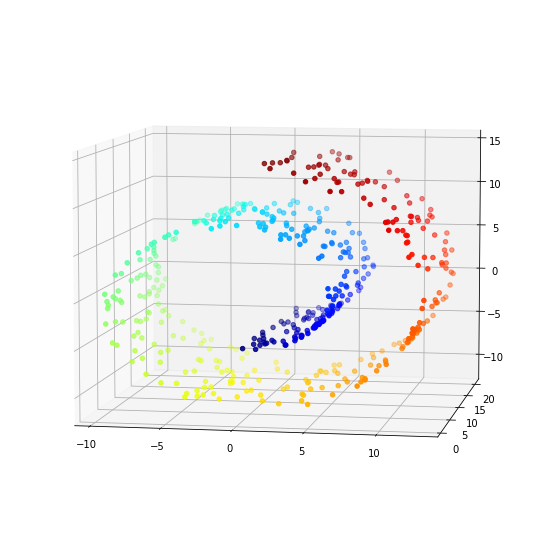

In [3]:
X, color = datasets.make_swiss_roll(random_state=42, n_samples = 500)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.jet)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.07it/s]


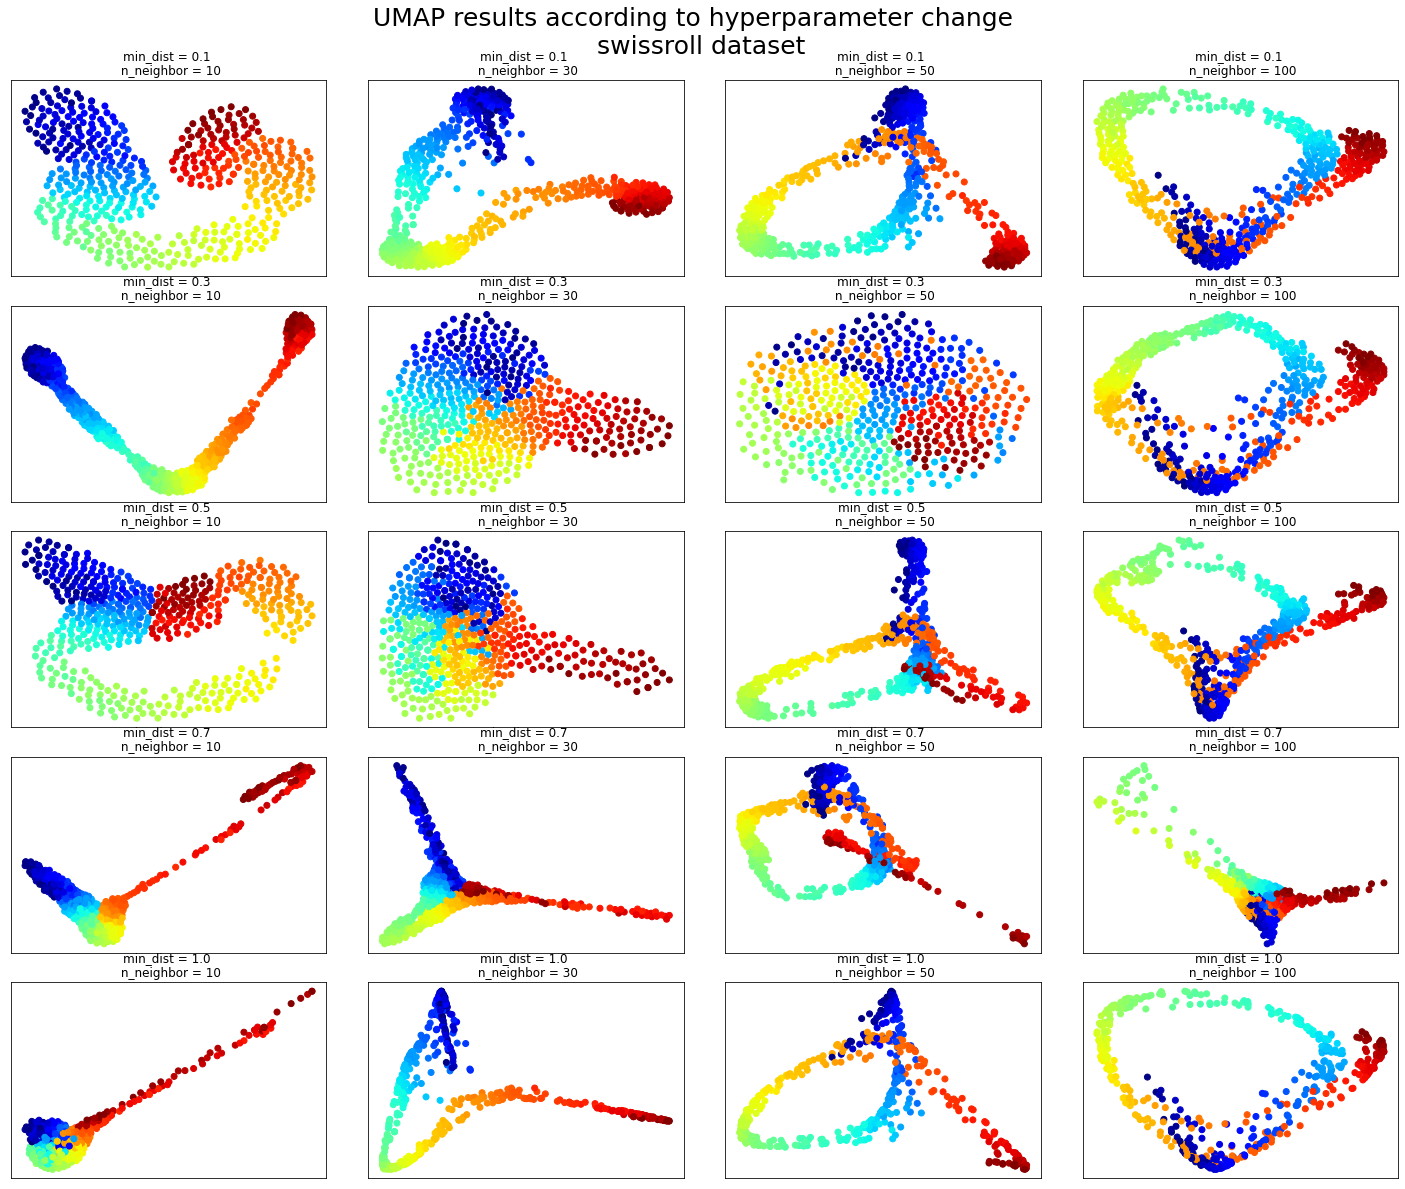

In [4]:
zz = [[idx1,idx2,m_d,n_n] for idx1, m_d in enumerate([.1, .3, .5, .7, 1.]) for idx2, n_n in enumerate([10, 30, 50, 100])]
fig, ax = plt.subplots(5,4, figsize = (20,17))
plt.tight_layout()

for z in zz:
    umap = UMAP(n_neighbors=z[3], n_components=2, min_dist = z[2], n_epoch= 50)
    umap.fit_transform(X)
    ax[z[0],z[1]].scatter(umap.low_dimension_[:,0], umap.low_dimension_[:,1], c = color, cmap = plt.cm.jet)
    ax[z[0],z[1]].set_title(f'min_dist = {z[2]} \n n_neighbor = {z[3]}')
    ax[z[0],z[1]].set_xticks([])
    ax[z[0],z[1]].set_yticks([])
fig.suptitle('UMAP results according to hyperparameter change \n swissroll dataset', fontsize = 25)
fig.subplots_adjust(top=0.92)

plt.savefig('UniformManifoldApproximationandProjection_visualize_varianceofresults_swissroll.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.41it/s]


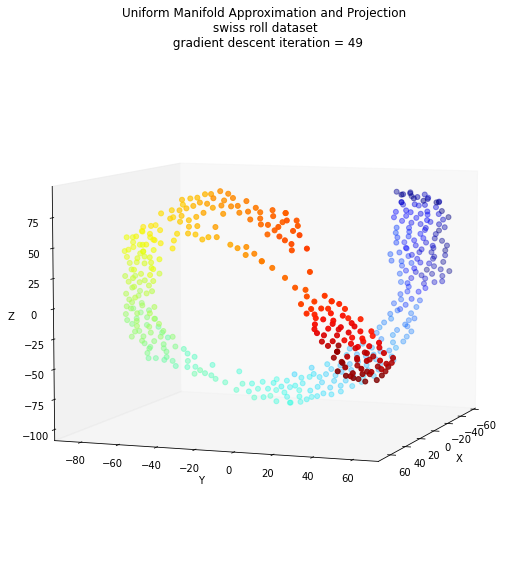

In [5]:
umap = UMAP(n_neighbors=10, n_components=3, min_dist = .2, n_epoch= 50)
umap.fit_transform(X)

time_steps = 50
N_nodes = 500

fig, ax = plt.subplots(figsize = (10, 10))
marker_size = 25 

def animate(i):
    fig.clear()
    ax = fig.add_subplot(111, projection = '3d')
    ax.set_xlim(umap.history_[-1][:,0].min()-1, umap.history_[-1][:,0].max() + 1)
    ax.set_ylim(umap.history_[-1][:,1].min()-1, umap.history_[-1][:,1].max() + 1)
    ax.set_zlim(umap.history_[-1][:,2].min()-1, umap.history_[-1][:,2].max() + 1)
    ax.view_init(7, 20)
    ax.grid(b = None)
    ax.set_title('Uniform Manifold Approximation and Projection \n swiss roll dataset \n gradient descent iteration = %d' % i)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    s = ax.scatter(umap.history_[i][:,0], umap.history_[i][:,1], umap.history_[i][:,2], s = marker_size, c = color, cmap = plt.cm.jet, marker = 'o', edgecolor = None)
plt.tight_layout()
fig.subplots_adjust(top=.75)

ani = animation.FuncAnimation(fig, animate, interval=150, frames=range(time_steps))

ani.save('UniformManifoldApproximationandProjectionGD_swissroll.gif', writer='pillow', dpi=100)

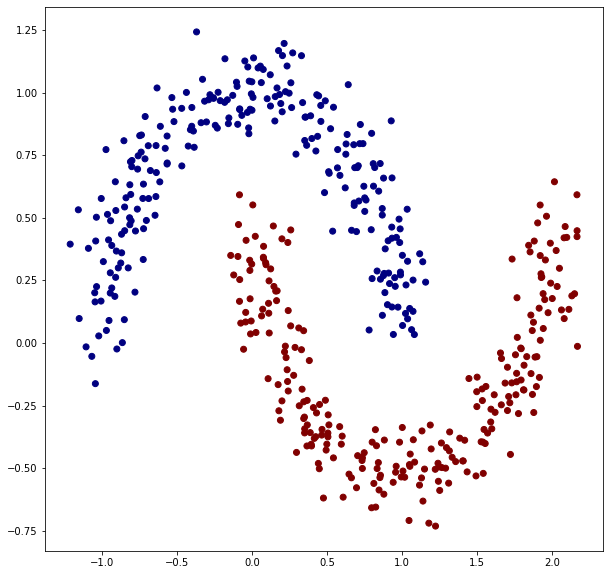

In [6]:
X2, color2 = datasets.make_moons(random_state=42, n_samples = 500, noise=.1)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(X2[:, 0], X2[:, 1], c=color2, cmap=plt.cm.jet)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.88it/s]


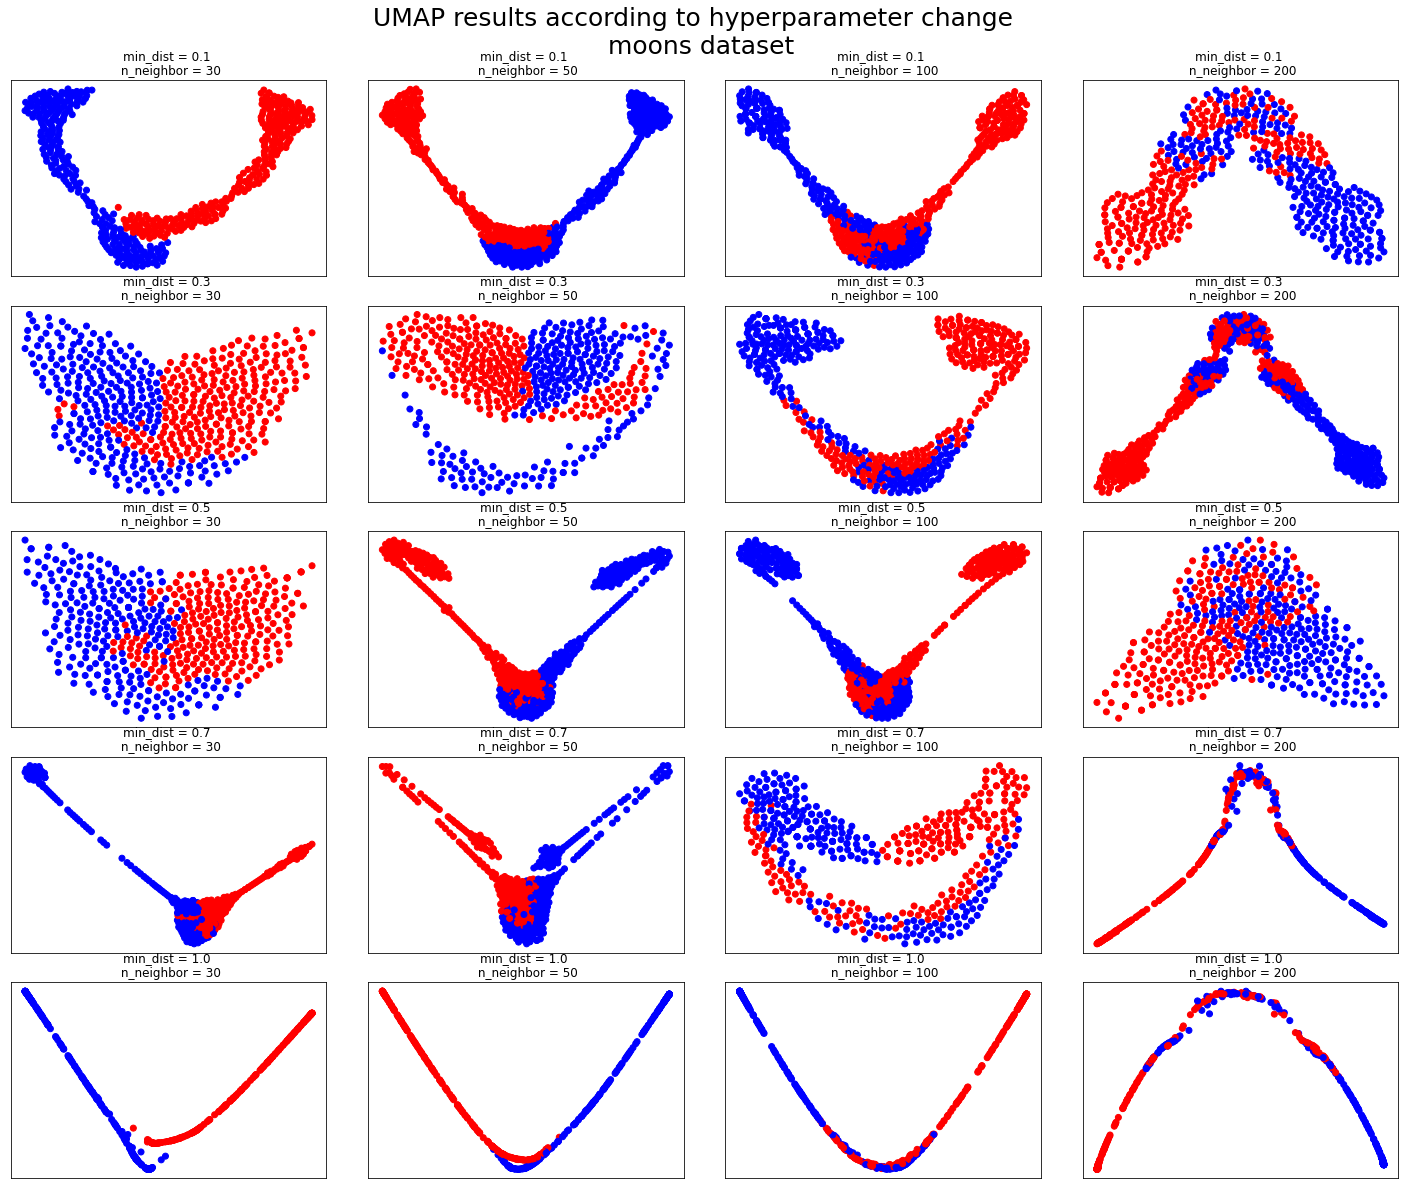

In [7]:
zz = [[idx1,idx2,m_d,n_n] for idx1, m_d in enumerate([.1, .3, .5, .7, 1.]) for idx2, n_n in enumerate([30, 50, 100, 200])]
fig, ax = plt.subplots(5,4, figsize = (20,17))
plt.tight_layout()

for z in zz:
    umap = UMAP(n_neighbors=z[3], n_components=2, min_dist = z[2], n_epoch= 50)
    umap.fit_transform(X2)
    ax[z[0],z[1]].scatter(umap.low_dimension_[:,0], umap.low_dimension_[:,1], c = color2, cmap = plt.cm.bwr)
    ax[z[0],z[1]].set_title(f'min_dist = {z[2]} \n n_neighbor = {z[3]}')
    ax[z[0],z[1]].set_xticks([])
    ax[z[0],z[1]].set_yticks([])
fig.suptitle('UMAP results according to hyperparameter change \n moons dataset', fontsize = 25)
fig.subplots_adjust(top=0.92)

plt.savefig('UniformManifoldApproximationandProjection_visualize_varianceofresults_moons.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.86it/s]


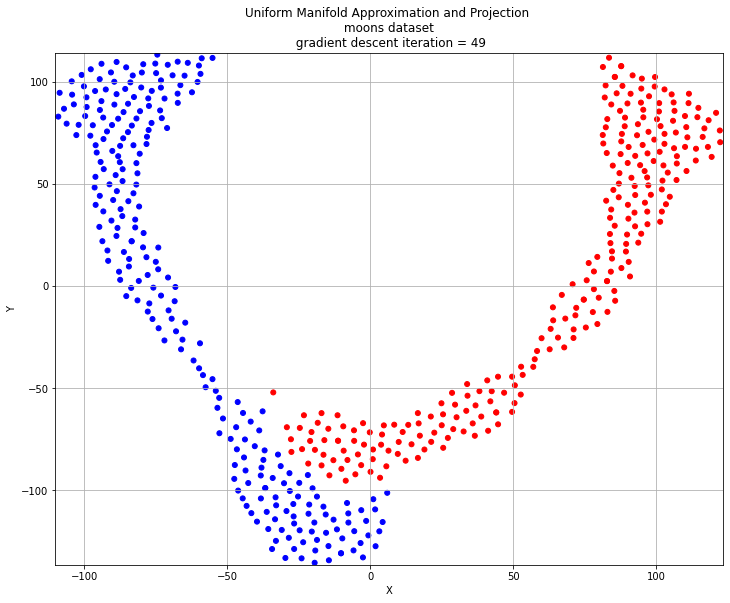

In [8]:
umap = UMAP(n_neighbors=30, n_components=2, min_dist = .1, n_epoch= 50)
umap.fit_transform(X2)

time_steps = 50
N_nodes = 500

fig, ax = plt.subplots(figsize = (10, 10))
marker_size = 25 

def animate(i):
    fig.clear()
    ax = fig.add_subplot(111)
    ax.set_xlim(umap.history_[-1][:,0].min()-1, umap.history_[-1][:,0].max() + 1)
    ax.set_ylim(umap.history_[-1][:,1].min()-1, umap.history_[-1][:,1].max() + 1)
    ax.grid(b = None)
    ax.set_title('Uniform Manifold Approximation and Projection \n moons dataset \n gradient descent iteration = %d' % i)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    s = ax.scatter(umap.history_[i][:,0], umap.history_[i][:,1], s = marker_size, c = color2, cmap = plt.cm.bwr, marker = 'o', edgecolor = None)
plt.tight_layout()
fig.subplots_adjust(top=.75)

ani = animation.FuncAnimation(fig, animate, interval=150, frames=range(time_steps))

ani.save('UniformManifoldApproximationandProjectionGD_moons.gif', writer='pillow', dpi=100)

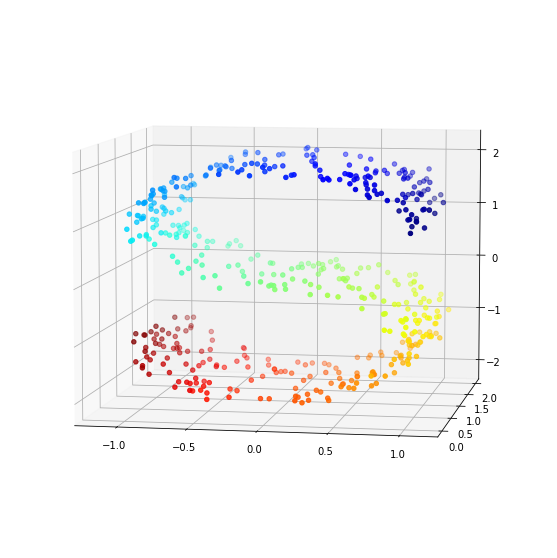

In [9]:
X3, color3 = datasets.make_s_curve(random_state=42, n_samples = 500, noise = .05)
X3
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(7, -80)
ax.scatter(X3[:, 0], X3[:, 1], X3[:,2], c=color3, cmap=plt.cm.jet)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.83it/s]


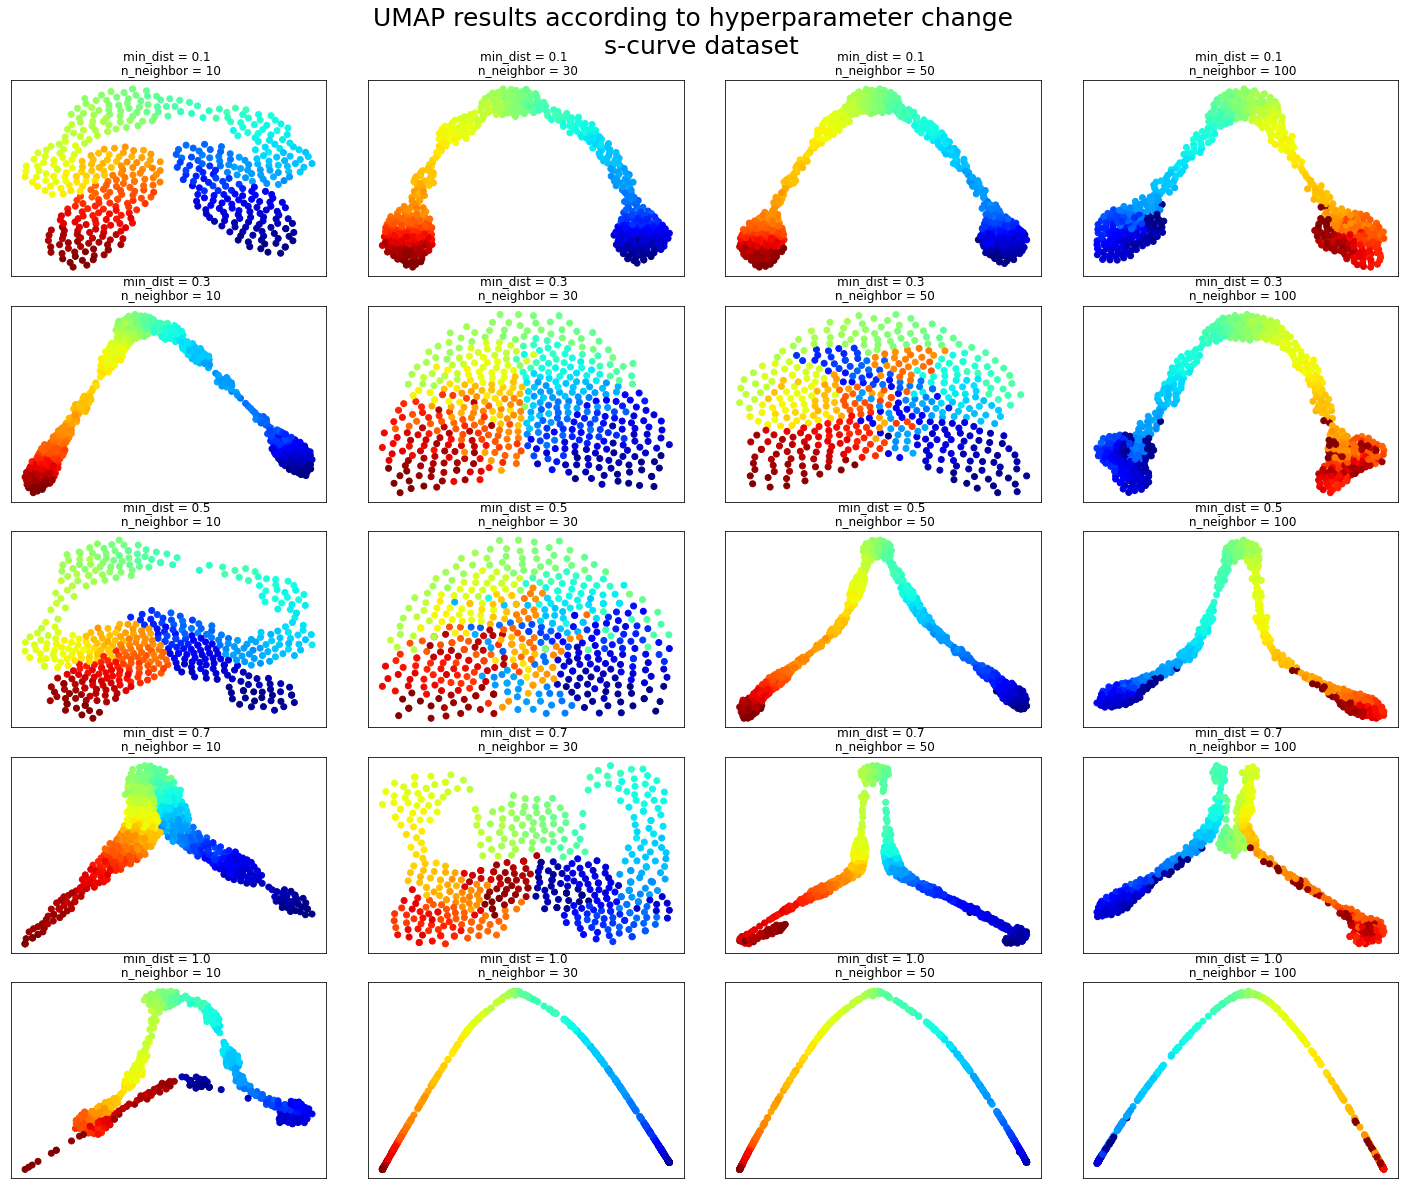

In [10]:
zz = [[idx1,idx2,m_d,n_n] for idx1, m_d in enumerate([.1, .3, .5, .7, 1.]) for idx2, n_n in enumerate([10, 30, 50, 100])]
fig, ax = plt.subplots(5,4, figsize = (20,17))
plt.tight_layout()

for z in zz:
    umap = UMAP(n_neighbors=z[3], n_components=2, min_dist = z[2], n_epoch= 50)
    umap.fit_transform(X3)
    ax[z[0],z[1]].scatter(umap.low_dimension_[:,0], umap.low_dimension_[:,1], c = color3, cmap = plt.cm.jet)
    ax[z[0],z[1]].set_title(f'min_dist = {z[2]} \n n_neighbor = {z[3]}')
    ax[z[0],z[1]].set_xticks([])
    ax[z[0],z[1]].set_yticks([])
fig.suptitle('UMAP results according to hyperparameter change \n s-curve dataset', fontsize = 25)
fig.subplots_adjust(top=0.92)

plt.savefig('UniformManifoldApproximationandProjection_visualize_varianceofresults_scurve.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.75it/s]


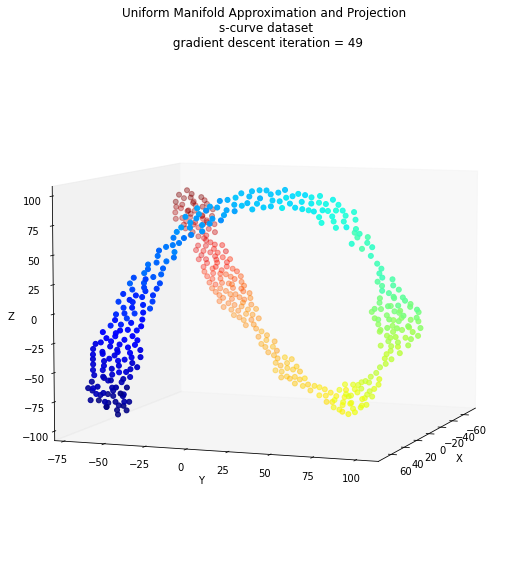

In [11]:
umap = UMAP(n_neighbors=30, n_components=3, min_dist = .1, n_epoch= 50)
umap.fit_transform(X3)

time_steps = 50
N_nodes = 500

fig, ax = plt.subplots(figsize = (10, 10))
marker_size = 25 

def animate(i):
    fig.clear()
    ax = fig.add_subplot(111, projection = '3d')
    ax.set_xlim(umap.history_[-1][:,0].min()-1, umap.history_[-1][:,0].max() + 1)
    ax.set_ylim(umap.history_[-1][:,1].min()-1, umap.history_[-1][:,1].max() + 1)
    ax.set_zlim(umap.history_[-1][:,2].min()-1, umap.history_[-1][:,2].max() + 1)
    ax.view_init(7, 20)
    ax.grid(b = None)
    ax.set_title('Uniform Manifold Approximation and Projection \n s-curve dataset \n gradient descent iteration = %d' % i)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    s = ax.scatter(umap.history_[i][:,0], umap.history_[i][:,1], umap.history_[i][:,2], s = marker_size, c = color3, cmap = plt.cm.jet, marker = 'o', edgecolor = None)
plt.tight_layout()
fig.subplots_adjust(top=.75)

ani = animation.FuncAnimation(fig, animate, interval=150, frames=range(time_steps))

ani.save('UniformManifoldApproximationandProjectionGD_scurve.gif', writer='pillow', dpi=100)

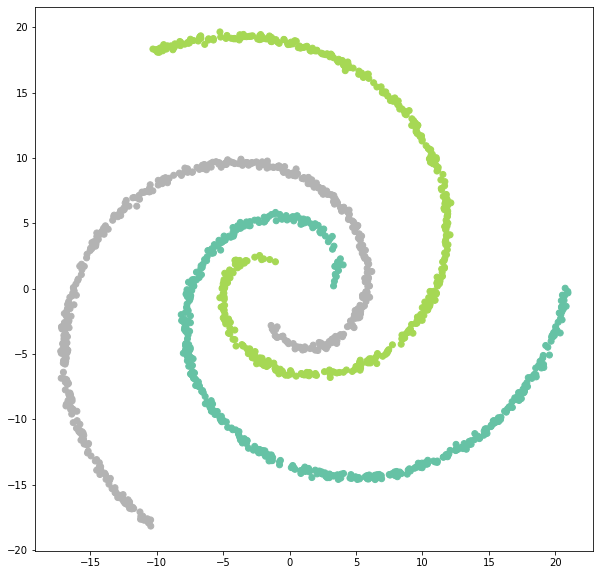

In [9]:
X4, color4 = soydata.data.classification.make_spiral(n_samples_per_class=500, n_classes=3,
n_rotations=1, gap_between_spiral=2, 
gap_between_start_point=2, equal_interval=True,                
noise=0.15)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(X4[:, 0], X4[:, 1], c=color4, cmap=plt.cm.Set2)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


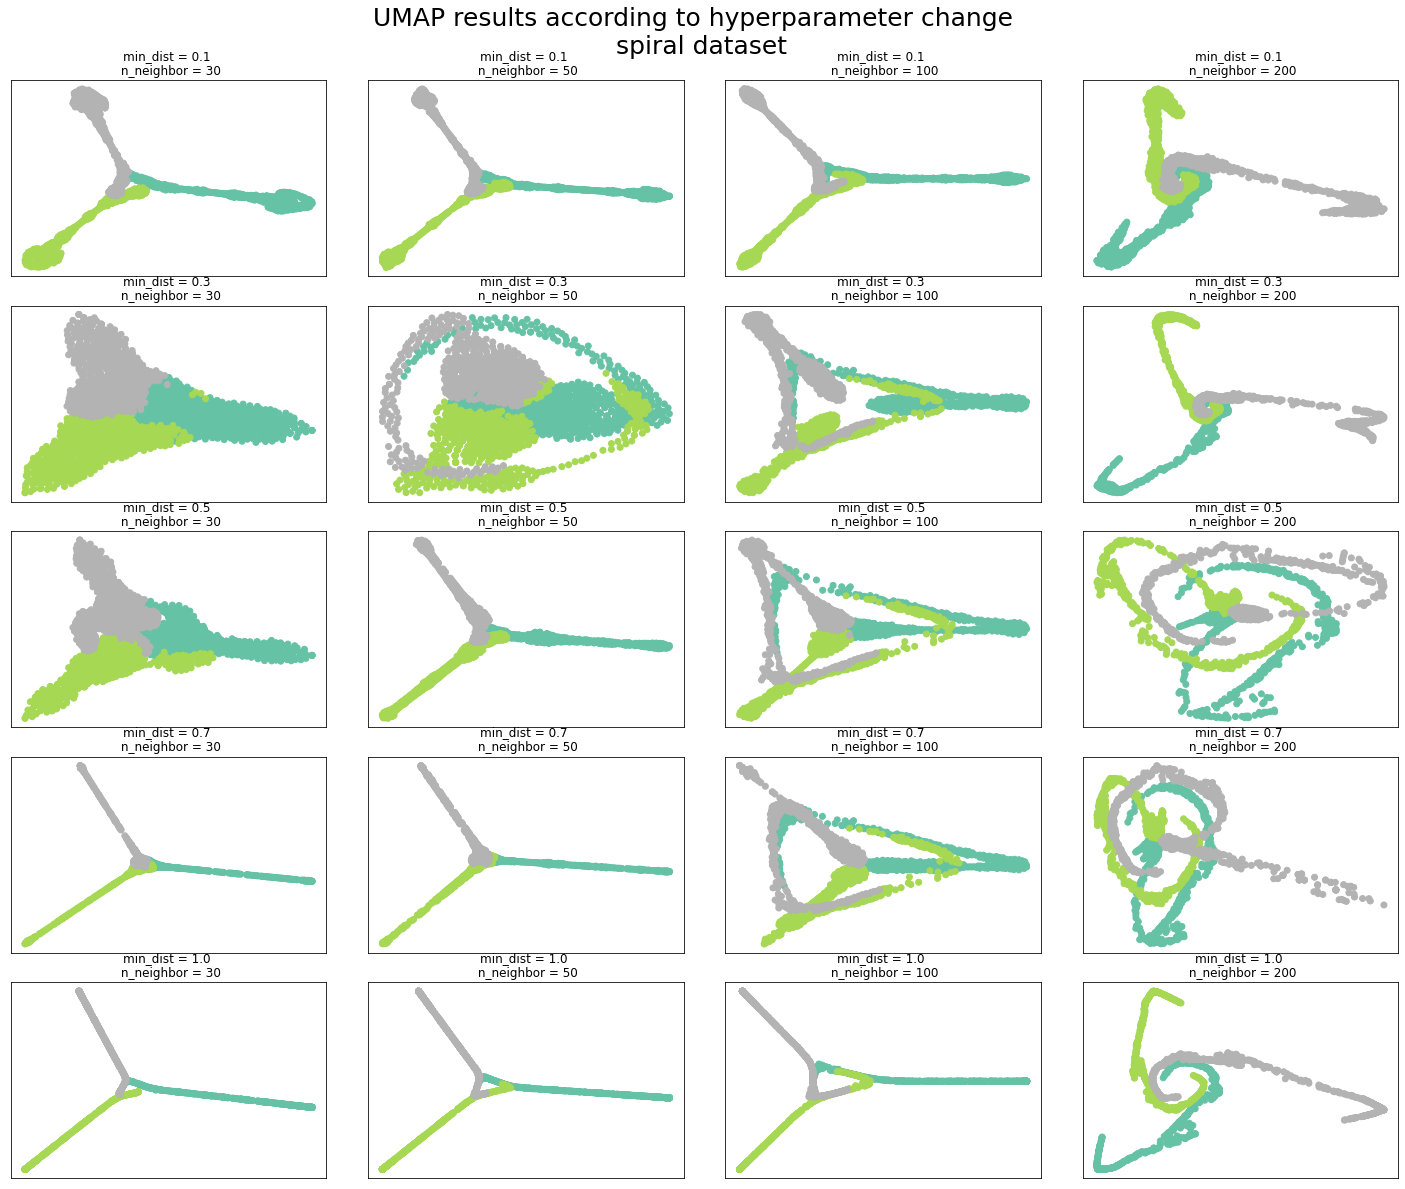

In [11]:
zz = [[idx1,idx2,m_d,n_n] for idx1, m_d in enumerate([.1, .3, .5, .7, 1.]) for idx2, n_n in enumerate([30, 50, 100, 200])]
fig, ax = plt.subplots(5,4, figsize = (20,17))
plt.tight_layout()

for z in zz:
    umap = UMAP(n_neighbors=z[3], n_components=2, min_dist = z[2], n_epoch= 50)
    umap.fit_transform(X4)
    ax[z[0],z[1]].scatter(umap.low_dimension_[:,0], umap.low_dimension_[:,1], c = color4, cmap = plt.cm.Set2)
    ax[z[0],z[1]].set_title(f'min_dist = {z[2]} \n n_neighbor = {z[3]}')
    ax[z[0],z[1]].set_xticks([])
    ax[z[0],z[1]].set_yticks([])
fig.suptitle('UMAP results according to hyperparameter change \n spiral dataset', fontsize = 25)
fig.subplots_adjust(top=0.92)

plt.savefig('UniformManifoldApproximationandProjection_visualize_varianceofresults_spiral.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


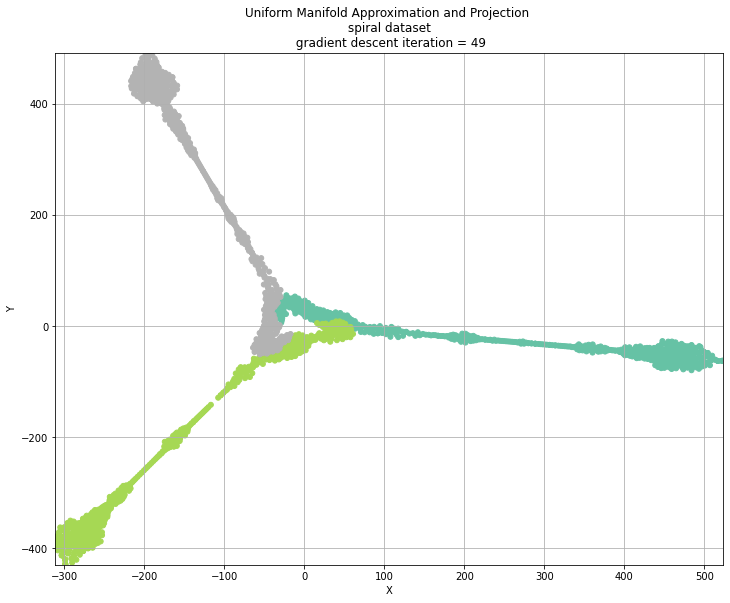

In [12]:
umap = UMAP(n_neighbors=50, n_components=2, min_dist = .1, n_epoch= 50)
umap.fit_transform(X4)

time_steps = 50
N_nodes = 500

fig, ax = plt.subplots(figsize = (10, 10))
marker_size = 25 

def animate(i):
    fig.clear()
    ax = fig.add_subplot(111)
    ax.set_xlim(umap.history_[-1][:,0].min()-1, umap.history_[-1][:,0].max() + 1)
    ax.set_ylim(umap.history_[-1][:,1].min()-1, umap.history_[-1][:,1].max() + 1)
    ax.grid(b = None)
    ax.set_title('Uniform Manifold Approximation and Projection \n spiral dataset \n gradient descent iteration = %d' % i)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    s = ax.scatter(umap.history_[i][:,0], umap.history_[i][:,1], s = marker_size, c = color4, cmap = plt.cm.Set2, marker = 'o', edgecolor = None)
plt.tight_layout()
fig.subplots_adjust(top=.75)

ani = animation.FuncAnimation(fig, animate, interval=150, frames=range(time_steps))

ani.save('UniformManifoldApproximationandProjectionGD_spiral.gif', writer='pillow', dpi=100)